date: 03/27/2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 10.3 Spectral Clustering

Spectral Clustering is an alternative clustering algorithm to k-means and Hierarchical Clustering.
Spectral Clustering can capture complex cluster structures and, unlike Hierarchical Clustering, can handle medium/large sized datasets.
Its drawback: Spectral Clustering has human-specified parameter $\sigma$. 
It is, however, possible to deduce a good parameter $\sigma$ by trial and error. 

Spectral clustering has a long history. 
As a machine learning method, it was popularized by Ng, Jordan, and Weiss:

https://ai.stanford.edu/~ang/papers/nips01-spectral.pdf

Spectral Clustering uses the eigenvectors of the **Laplacian matrix**. The Laplacian matrix is constructed as follows.
First, we form the **affinity matrix**. The affinity matrix $A$ is an $m\times m$ (where $m$ is the size of the dataset) whose $(i,j)$ entry is

$$
A_{ij} = \exp \left(\frac{-\|x_i-x_j\|_2^2}{2\sigma^2}\right).
$$

The parameter $\sigma$ controls how rapidly the affinity $A_{ij}$ falls off with the distance between the points $x_i$ and $x_j$.

Second, we form the **degree matrix**. The degree matrix $D$ is an $m\times m$ diagonal matrix whose $(i,i)$ entry is the sum of A's $i$th row.

$$
D_{ii} = \sum_{j=1}^m A_{ij}.
$$

The **Laplaciam matrix** is the symmetric matrix

$$
L = D^{-1/2} A D^{-1/2},
$$

where $D^{-1/2}$ denotes the matrix inverse of $D^{1/2}$, and where $D^{1/2}$ is a diagonal matrix whose $(i,i)$ entry is the square root of the $(i,i)$ entry of $D$.

In [2]:
def Laplacian_matrix(X,sigma):
    
    'dataset size and number of features'
    m,n=X.shape
    
    'affinity matrix'
    A = np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            A[i,j] = np.linalg.norm(X[i]-X[j])
    A = np.exp(-A/(2*sigma**2))
    
    'degree matrix'
    D = np.sum(A,axis=1)
    
    'return Laplacian matrix'
    return ((A/np.sqrt(D)).T/np.sqrt(D)).T

**Spectral Clustering** works as follows: given a set of points $x_1,\ldots,x_m$ that we want to cluster into $k$ subsets:

**step 1**. Form the Laplacian matrix

**step 2**. Find the eigenvectors $v_1,v_2,\ldots,v_k$ of the Laplacian matrix corresponding to the $k$ largest eigenvalues. Form the matrix

$$
V = 
\begin{bmatrix}
    v_1 & v_2 & \cdots & v_k
\end{bmatrix}
$$

by staking the eigenvectors in columns.

**step 3**. Normalize each of $V$'s rows to have unit norm.

**step 4**. Treating each row of $V$ as a point, cluster them into $k$ clusters via the $k$-means algorithm (or any other cluster algorithm)

**step 5**. Assign the orinal point $x_i$ to cluster $j$ if and only if row $i$ of $V$ was assigned to cluster $j$.

## 10.3.1 Spectral Clustering Step by Step

Let us consider the following dataset with two clusters.

Text(0.5, 1.0, 'ring-shaped dataset')

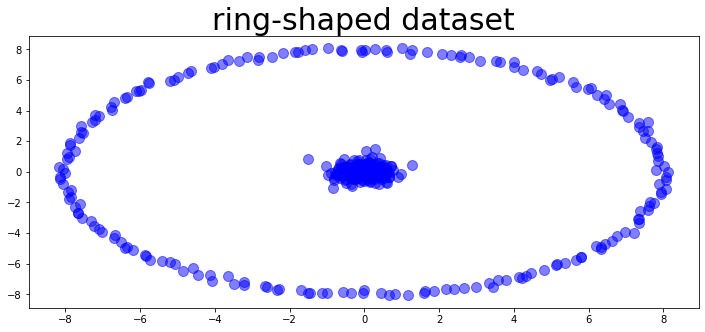

In [3]:
X = np.zeros((400,2))

# cluster 1:
theta = np.linspace(0,2*np.pi,200) 
X[0:200,0] = 8*np.sin(theta)+0.1*np.random.randn(200)
X[0:200,1] = 8*np.cos(theta)+0.1*np.random.randn(200)
# cluster 2:
X[200:400] = 0.4*np.random.randn(200,2)

plt.figure(figsize=(12,5))
plt.plot(X[:,0],X[:,1],'bo',alpha=0.5,markersize=10)
plt.title('ring-shaped dataset',fontsize=30)

We begin by forming the Laplacian matrix

In [4]:
sigma = 1
L = Laplacian_matrix(X,1)

Second, we compute the eigenvectors with the $k=2$ largest eigenvalues.
To do this, we'll use the function eigs in the scipy library.

In [14]:
# import scipy
# _,V = scipy.sparse.linalg.eigs(L, k=2,which='LM') #'LM' = largest magnitude
from scipy.sparse.linalg import eigs
_,V = eigs(L, k=2,which='LM') #'LM' = largest magnitude

Third, we normalize the rows of V

In [15]:
'normalize rows'
V = V/np.linalg.norm(V,axis=1,keepdims=True)
V = np.real(V) # remove the imaginary parts (which are all equal to 0)

Now the magic. Steps 1--3 maps the original points to points in the unit circle. The two original clusters (the outer circle and the blob at the origin) are transformed into two tight clusters that lie at 90 degrees to each other relative to the origin.

Text(0.5, 1.0, 'transformed dataset')

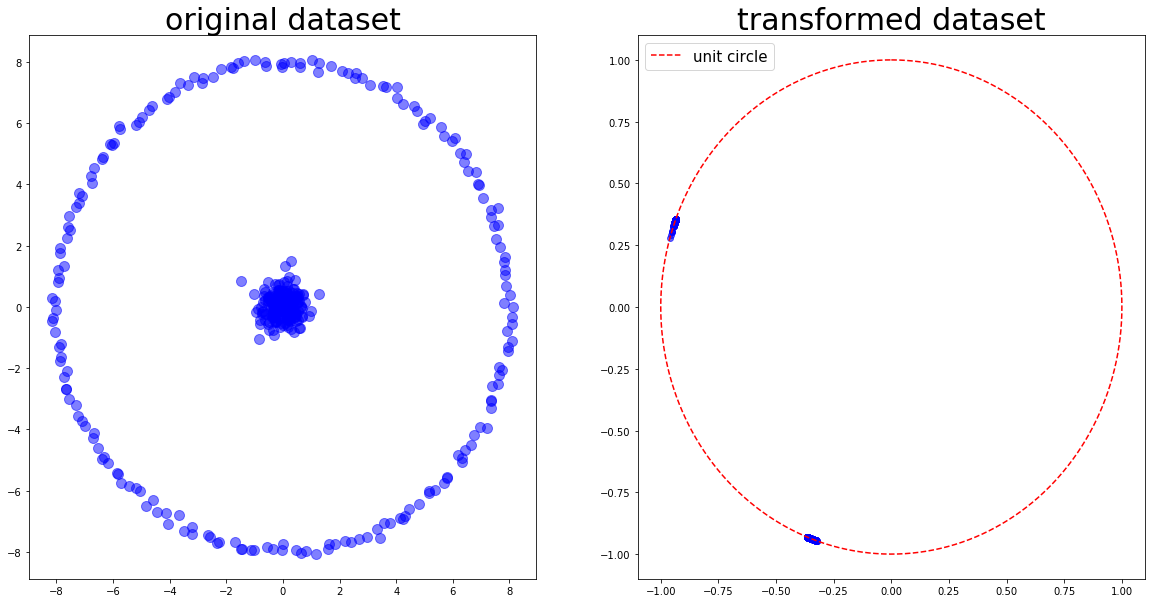

In [16]:
plt.figure(figsize=(20,10))

'original dataset'
plt.subplot(1,2,1)
plt.plot(X[:,0],X[:,1],'bo',alpha=0.5,markersize=10)
plt.title('original dataset',fontsize=30)

'transformed dataset + unit circle'
theta = np.linspace(0,2*np.pi,1000) 
x_unit_circle = np.sin(theta)
y_unit_circle = np.cos(theta)
plt.subplot(1,2,2)
plt.plot(V[:,0],V[:,1],'bo',alpha=0.6)
plt.plot(x_unit_circle,y_unit_circle,'r--',label='unit circle')
plt.legend(fontsize=15,loc='upper left')
plt.title('transformed dataset',fontsize=30)

The transformed clusters can be easily found by the k-means algorithm

In [17]:
def k_means(X,k,max_it=1000000):   
    it = 0 
    m,n = X.shape #dataset size, number of features
    repeat = True 
    'random initialization of clusters'
    clusters = np.random.randint(k,size=len(X)) # random assignment
    'means initialization'
    means = np.zeros((k,n))
    while repeat and it<=max_it: # repeat until clusters do not change or iterations > max_it
        it = it + 1
        'step 1: update means'
        for i in range(k):
            if len(X[clusters==i])!=0:
                means[i] = np.mean(X[clusters==i],axis=0)
            else: # if any of the cluster centers has no data points associated with it, replace it with a random data point
                idx = np.random.randint(m)
                means[i] = X[idx]
        'step 2: update clusters'
        new_clusters = np.argmin(np.array([np.linalg.norm(X-means[i],axis=1) for i in range(k)]),axis=0)        
        'check whether clusters and new_clusters are equal or not'
        if sum(clusters!=new_clusters)==0:
            repeat = False
        clusters = new_clusters
    return clusters, means

In [18]:
'apply k-means'
clusters,_ = k_means(V,k=2)

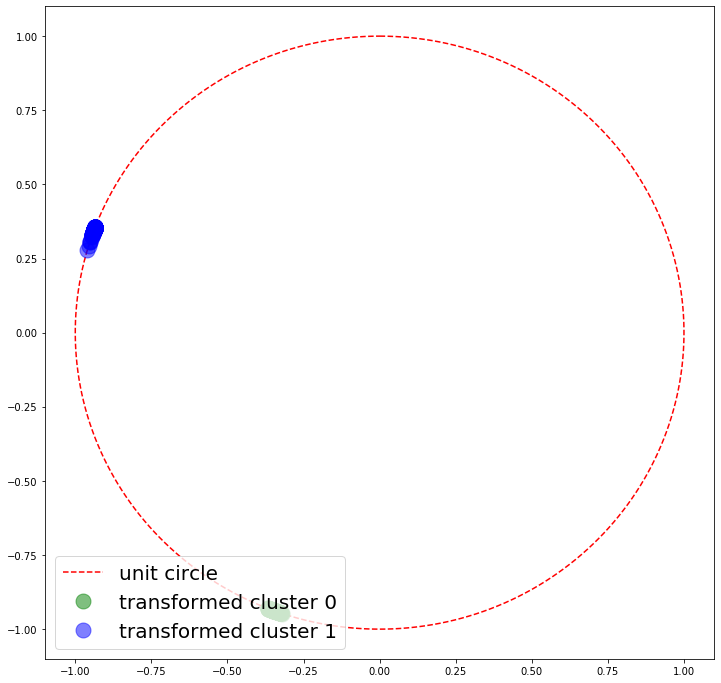

In [19]:
colors = ['green','blue']
plt.figure(figsize=(12,12))
plt.plot(x_unit_circle,y_unit_circle,'r--',label='unit circle')
k=2
for i in range(k):
    plt.plot(V[clusters==i,0],V[clusters==i,1],'o',color=colors[i],label = 'transformed cluster '+str(i),alpha=0.5,markersize=15)
    plt.legend(fontsize=20, loc='lower left')

Back to the original dataset

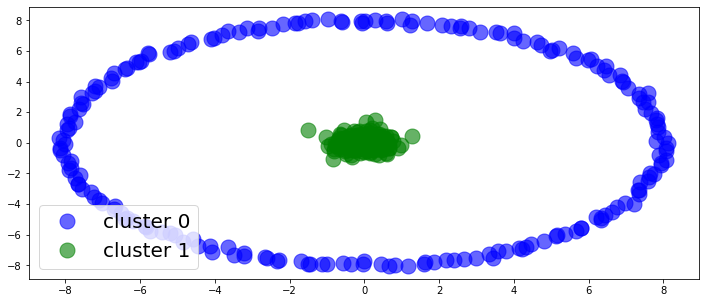

In [20]:
colors = ['blue','green']
plt.figure(figsize=(12,5))
k=2
for i in range(k):
    'plot dataset points'
    plt.plot(X[clusters==i,0],X[clusters==i,1],'o',color=colors[i],label = 'cluster '+str(i),alpha=0.6,markersize=15)
    plt.legend(fontsize=20, loc='lower left')

## 10.3.2 Spectral Clustering Implementation

In [12]:
def spectral_clustering(X,k,sigma):
    
    'form Laplacian matrix'
    L = Laplacian_matrix(X,1)
    
    'find k largest eigenvectors'
    _,V = scipy.sparse.linalg.eigs(L, k=2,which='LM')
    
    'normalize rows of V'
    V = V/np.linalg.norm(evectors,axis=1,keepdims=True)
    V = np.real(V) # remove the imaginary parts (which are all equal to 0)
    
    'apply k-means to rows of V'
    clusters,_ = k_means(V,k)
    
    return clusters

## 10.3.3 Questions/Problems (some of these problems might appear in Homework 7)

**Problem 1:** try to replicate the examples in Section 4 (see Figure 1) in the paper https://ai.stanford.edu/~ang/papers/nips01-spectral.pdf

